In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from PIL import Image
import os

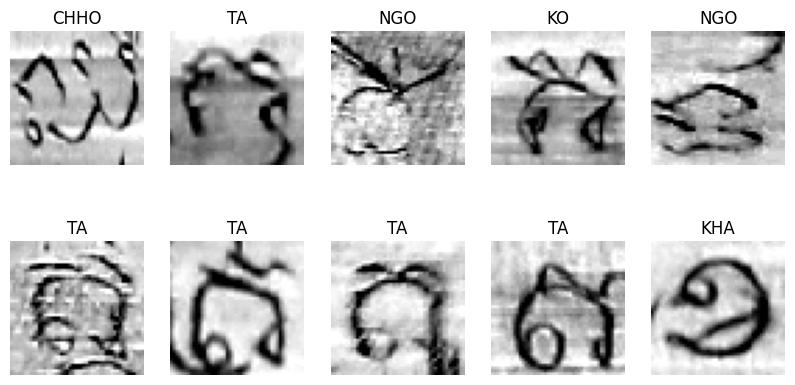

In [2]:
# khmer MNIST dataset
train = pd.read_csv('data/kh_char_train.csv', header=None)
test = pd.read_csv('data/kh_char_test.csv', header=None)

# split data into X and y
X_train = train.iloc[:, 1:].values
y_train = train.iloc[:, 0].values
X_test = test.iloc[:, 1:].values
y_test = test.iloc[:, 0].values

# plot some images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i].reshape(48, 48), cmap='gray')
    ax.set_title(y_train[i])
    ax.axis('off')
plt.show()

In [3]:
len(train), len(test)

(17361, 13898)

In [4]:
# U net model for segmentation
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split

In [5]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        # Encoder
        self.down1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.down4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Decoder
        self.up4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(512 + 256, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(256 + 128, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(128 + 64, 64)
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.down1(x)
        p1 = self.pool1(x1)
        x2 = self.down2(p1)
        p2 = self.pool2(x2)
        x3 = self.down3(p2)
        p3 = self.pool3(x3)
        x4 = self.down4(p3)
        p4 = self.pool4(x4)

        # Decoder
        up4 = self.up4(p4)
        merge4 = torch.cat([up4, x4], dim=1)
        x = self.conv4(merge4)

        up3 = self.up3(x)
        merge3 = torch.cat([up3, x3], dim=1)
        x = self.conv3(merge3)

        up2 = self.up2(x)
        merge2 = torch.cat([up2, x2], dim=1)
        x = self.conv2(merge2)

        output = self.final_conv(x)
        return output


In [6]:
class MNISTSegmentation(Dataset):
    def __init__(self, dataframe):
        """
        dataframe: A pandas DataFrame where each row is an image (flattened)
                   The first column is a label or identifier which we will ignore for image processing.
        """
        # Exclude the first column which contains labels or identifiers
        self.images = dataframe.iloc[:, 1:].values  # Take all rows, skip the first column
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        
        image = self.images[idx].reshape(48, 48).astype(np.uint8)
        image = Image.fromarray(image)  
        image = self.transform(image)   
        
        # Create a simple segmentation mask: all non-zero pixels are part of the "character"
        mask = (image[0] > 0).float()  # Convert to binary mask and ensure to use the channel dimension
        return image, mask

In [7]:
# split test into test and val
train, val = train_test_split(train, test_size=0.5)

# create dataset
train_dataset = MNISTSegmentation(train)
val_dataset = MNISTSegmentation(val)
test_dataset = MNISTSegmentation(test)

batch_size = 256

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
# create the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.cuda.get_device_name())
model = UNet(1, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

cuda
NVIDIA GeForce RTX 3070 Ti Laptop GPU


In [9]:
num_epochs = 60
train_losses = []
val_losses = []

def train_one_epoch(model, device, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        masks = masks.unsqueeze(1) 

        optimizer.zero_grad()
        outputs = model(images)
        outputs = torch.nn.functional.interpolate(outputs, size=(48, 48), mode='bilinear', align_corners=False)

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    return total_loss / len(train_loader)

def validate(model, device, val_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            masks = masks.unsqueeze(1)

            outputs = model(images)
            outputs = torch.nn.functional.interpolate(outputs, size=(48, 48), mode='bilinear', align_corners=False)

            loss = criterion(outputs, masks)
            total_loss += loss.item() * images.size(0)
    return total_loss / len(val_loader.dataset)

In [10]:
for epoch in range(num_epochs):
    start_time = time.time()
    train_loss = train_one_epoch(model, device, train_loader, optimizer, criterion)
    val_loss = validate(model, device, val_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    print(f"Duration: {time.time() - start_time:.2f} seconds")

Epoch 1/60, Train Loss: 0.3249, Val Loss: 0.2647
Duration: 7.00 seconds
Epoch 2/60, Train Loss: 0.1906, Val Loss: 0.1669
Duration: 6.76 seconds
Epoch 3/60, Train Loss: 0.1356, Val Loss: 0.1262
Duration: 6.81 seconds
Epoch 4/60, Train Loss: 0.1073, Val Loss: 0.1092
Duration: 6.80 seconds
Epoch 5/60, Train Loss: 0.0906, Val Loss: 0.0867
Duration: 6.87 seconds
Epoch 6/60, Train Loss: 0.0791, Val Loss: 0.0756
Duration: 6.81 seconds
Epoch 7/60, Train Loss: 0.0712, Val Loss: 0.0672
Duration: 6.88 seconds
Epoch 8/60, Train Loss: 0.0661, Val Loss: 0.0692
Duration: 6.90 seconds
Epoch 9/60, Train Loss: 0.0610, Val Loss: 0.0582
Duration: 6.90 seconds
Epoch 10/60, Train Loss: 0.0567, Val Loss: 0.0536
Duration: 6.95 seconds
Epoch 11/60, Train Loss: 0.0532, Val Loss: 0.0532
Duration: 6.95 seconds
Epoch 12/60, Train Loss: 0.0501, Val Loss: 0.0470
Duration: 6.84 seconds
Epoch 13/60, Train Loss: 0.0471, Val Loss: 0.0448
Duration: 6.85 seconds
Epoch 14/60, Train Loss: 0.0450, Val Loss: 0.0438
Duration: 

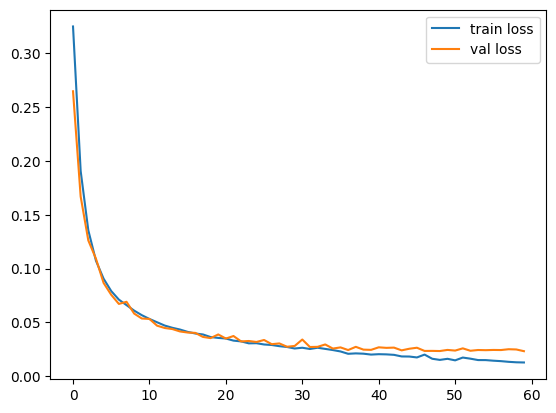

In [11]:
# plot the losses
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.legend()
plt.show()

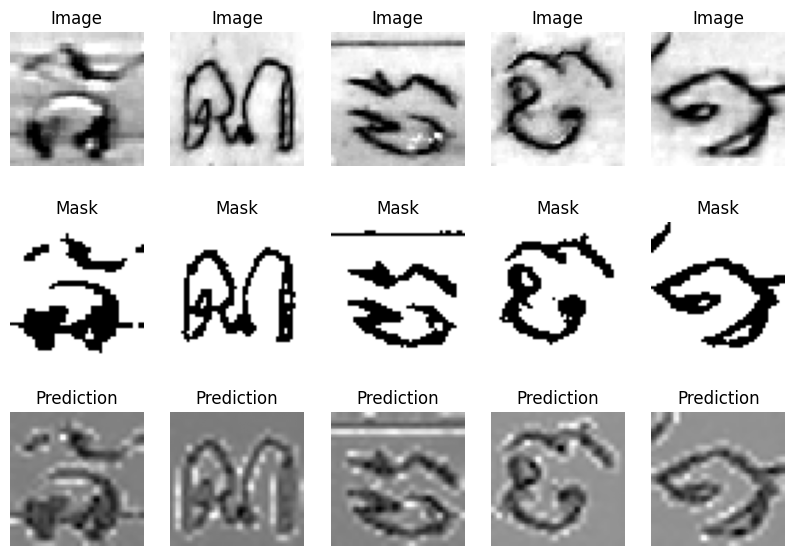

In [12]:
# plot some predictions
def pic_and_mask(model, device, test_loader):
    model.eval()
    images, masks = next(iter(test_loader))
    images = images.to(device)
    masks = masks.to(device)
    masks = masks.unsqueeze(1)  # Ensure masks have a channel dimension

    with torch.no_grad():
        outputs = model(images)
        outputs = torch.nn.functional.interpolate(outputs, size=(48, 48), mode='bilinear', align_corners=False)
    return images, masks, outputs

images, masks, outputs = pic_and_mask(model, device, test_loader)

fig, axes = plt.subplots(3, 5, figsize=(10, 7))
for i, ax in enumerate(axes.flat):
    if i < 5:
        ax.imshow(images[i][0].cpu(), cmap='gray')
        ax.set_title('Image')
    elif i < 10:
        ax.imshow(masks[i-5][0].cpu(), cmap='gray')
        ax.set_title('Mask')
    else:
        ax.imshow(outputs[i-10][0].cpu(), cmap='gray')
        ax.set_title('Prediction')
    ax.axis('off')

In [13]:
# save the model and everything
os.makedirs('U-net save', exist_ok=True)
torch.save(model.state_dict(), 'U-net save/model.pth')
torch.save(optimizer.state_dict(), 'U-net save/optimizer.pth')
torch.save({
    'train_losses': train_losses,
    'val_losses': val_losses
}, 'U-net save/losses.pth')